# Semi Parammetric Latent Factor Model For multitrials

here we introduce S trials for each Y. To accomodate these we fold up Y's in vectorized form
#### Now, $Y \in R^{S \times CN}, u \in R^{S \times PN }$ and ${ \bar{\phi} }$ is a block diagonal of size CN X PN with CXP matrix ${\phi}$ on diagonal

###  $Y= u * \bar{\phi}^T + \sigma^2I$

##### Also, $u \in GP(0,\bar{K})$ where $\bar{K}$ is also a blaock diagonal of size PN x PN with covariance kernels ${K_p \in R ^{N \times N}}$ for each  gaussian process on diagonals.

In [1]:
### necessary Imports
import numpy as np
import pylab as pb
import scipy as sc
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as MNormalDist
import GPy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### True Model:

Here we generate our data that we can later use to check our solution

#### $ \bar{\phi} = \phi \otimes I_{N \times N}$ where ${ \phi \in N(0,I)}$
Where ${\otimes}$ is kronecker product.

#### $u$

First we have similar kernels so that processes can be easily distinguished
We choose one as a exponential quad Kernel with shorter length scale.

Phi
[[ 0.58563905  0.80522675]
 [-0.34061553  0.51256034]
 [-0.13094327  1.31816634]]


<matplotlib.colorbar.Colorbar instance at 0x7f2c04cb13f8>

 /usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


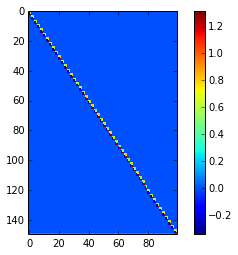

In [2]:
S = 2
P = 2
C = 3
N = 50
s2 = 0.5
x = np.linspace(0,N-1,N)
phi = np.random.normal(loc=0,scale=1,size=(C,P))
phiBar = np.matrix(np.kron(np.eye(N),phi))
print "Phi\n",phi
plt.imshow(phiBar,interpolation='none')
plt.colorbar()

In [3]:
class Kernel:
    @staticmethod
    def fetchParams(intializations,passed):
        params ={}
        for param in intializations:
            if param in passed:
                params[param] = passed[param]
            else:
                params[param] = intializations[param]
        return params
    
    @staticmethod
    def exponenQuad(x,xprime,a=1,l=0.5,**kwargs):
        if kwargs:
            if kwargs['a']:
                a = kwargs['a']
            if kwargs['l']:
                l = kwargs['l'] 
        return a*np.exp((-0.5*(x - xprime)**2)/l**2)
    
    @staticmethod
    def periodic(x,xprime,**kwargs):
        initializations = { 'a':1,
                            'p':0.5,
                            'l':0.5}
        params = Kernel.fetchParams(initializations,kwargs)
        return params['a']*np.exp((-2*np.sin(np.pi* np.abs(x - xprime)/(params['p']))**2)/(params['l']**2))
        
    @staticmethod
    def linear(x,xprime,**kwargs):
        initializations = { 'a': 0.3}
        params = Kernel.fetchParams(initializations,kwargs)
        return params['a']*(x*xprime)
    
    @staticmethod
    def generateKernel(kernelFunc,x,xprime,**kwargs):
        kernel = np.zeros((x.size,xprime.size))
        for i in range(x.size):
            for j in range(xprime.size):
                kernel[i,j] = kernelFunc(x[i],xprime[j],**kwargs)
        return np.mat(kernel)

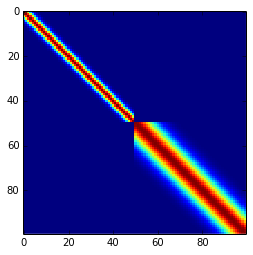

In [4]:
Kp = list()
for p in range(P):
    Kp.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=2+4*p))
#K.append(Kernel.generateKernel(Kernel.linear,x,x,a=0.001))
#K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=2))
Kbar = sc.linalg.block_diag(*Kp)
plt.imshow(Kbar,interpolation='none')

Concatenated Latent Gaussian Processes:


 /home/nautiys1/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning:covariance is not positive-semidefinite.


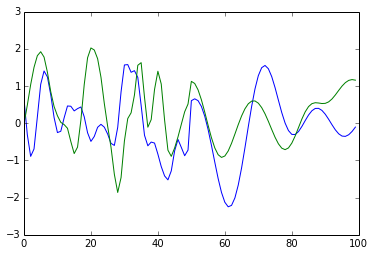

In [5]:
#Latent Gaussian Processes:
uBar = np.matrix(np.ones((S,N*P)))
for s in range(S):
    u = list()
    for p in range(P):
        u.append(np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=Kp[p]))
    us = np.hstack(u)
    uBar[s,:] = us        
print "Concatenated Latent Gaussian Processes:"
i=plt.plot(uBar.T)
    #uBar = np.
    

Generated Data:


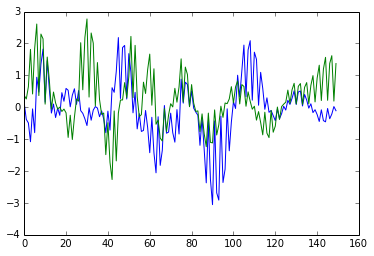

In [6]:
YBar = uBar * phiBar.T
print "Generated Data:"
i=plt.plot(YBar.T)

### Variational Inference, 
- introduce random inducing points
- initialize everything that we need
- Sice now everything is stacked we will use indices as nbar and Nbar

Concatenated Latent Gaussian Processes:
(240, 240) (2, 240, 1)


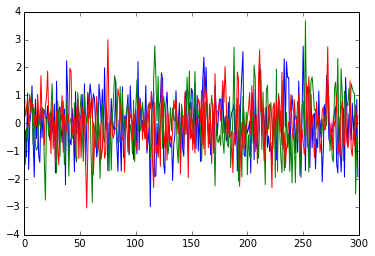

In [58]:
## get random inducing point
## Intialization for variational inference
P=6
noOfInductions = int(N*0.8)
n = sort(np.random.choice(x,size=noOfInductions,replace=False))
nBar = np.concatenate([c*N+n for c in range(C)])
NBar = np.concatenate([c*N+x for c in range(C)])
# Create Matrices
Knn = list()
KNn = list()
KnnInv = list()
KNN = list()
for i in range(P):
    Knn.append(Kernel.generateKernel(Kernel.exponenQuad,n,n,l=2,a=1))
    KNn.append(Kernel.generateKernel(Kernel.exponenQuad,x,n,l=2,a=1))
    KNN.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=2,a=1))
    KnnInv.append(np.linalg.inv(Knn[i]))
Kpnn = np.matrix(sc.linalg.block_diag(*Knn))
KpNn = np.matrix(sc.linalg.block_diag(*KNn))
KpnnInv = np.matrix(sc.linalg.block_diag(*KnnInv))
KpNN = np.matrix(sc.linalg.block_diag(*KNN))
# Generate a guess for phi
phiHatMean = 0
phiHatV = 1
phiHatExp = np.mat(np.random.normal(loc=phiHatMean,scale=phiHatV,size=(C,P)))
phiHatExpBar = np.kron(np.eye(N),phiHatExp)
#Generate samples for latent
uHatMeansBar = np.random.normal(loc=0,scale=1,size=(S,noOfInductions*P,1))
uHatVsBar = np.eye(noOfInductions*P)
uExpBar = np.random.normal(loc=0,scale=1,size=(S+1,N*P))
print "Concatenated Latent Gaussian Processes:"
i=plt.plot(uExpBar.T)
print uHatVsBar.shape,uHatMeansBar.shape


### Variational Updates are:

#### For ${\hat{u}}$:

$q(\hat{u}) \propto N(u|y<\phi>{K}_{pNpn}K_{pn}^{-1}\Sigma_{u}^{-1}, \hat{\Sigma}_{u}^{-1})$
where $ \hat{\Sigma}_{u} = K_{pn}^{-1} + \frac{1}{\sigma^2}K_{pn}^{-1}K_{pnpN}F_uK_{pNpn}K_{pn}^{-1}$
and $F_u = <{\phi}^T{\phi}>_{\phi} = Var(\phi) + <\phi>^T<\phi>$ , 

#### For ${u}$:

${q(u) \propto N (\hat{\mu}M, \Sigma_{u|u^{p}} + M\Sigma_{u}M^{T})}$


where $\hat{\mu}_{u}$ is the mean and ${\hat{\Sigma}_{u}}$ variance of $\hat{u}$

Also  $\Sigma_{u|u^{p}} = K_{pNpN} - K_{pNpn}K_{pn}^{-1}K_{pnpN}$ , $M = K_{pn}^{-1}K_{pNpn}$

#### For $\phi$:

$\phi = N((V_{\phi} + I)^{-1}<U>^{T}y, V_{\phi} + I)^{-1})$
where $V_{\phi} = <U^{T}U>_{u}$

##### After recalculation
$\phi = N(\phi| (\bar{V}_{\phi} + I)^{-1}\bar{z}_{\phi}, (\bar{V}_{\phi} + I)^{-1})$
where $\bar{V}_{\phi} = \sum_{s}^{S}(<\bar{u}_s><\bar{u}_s>^T$ + I)
and $\bar{z}_{\phi} = \sum_{s}^{S}<\bar{u}_s>\bar{y}_{s}^T$
here $x = vec(\bar{x})$ 
### And lower bound of liklelihood with respect to $u_p$ is given by:

$L(u_p) = log N(F_{p}^{-1}y<\phi> | <U>, F_{p}^{-1} + K_{Nn}K_{nn}^{-1}K_{nN}) - \frac{1}{2}tr(\sum_{i}^{P}{U_i*cov(u_i|\hat{u_i}}))$ - KL divergence terms.. 

where
$ cov(u_p|\hat{u}_p) = K_N - K_{Nn}K_{n}^{-1}K_{nN}$


In [48]:
#Calculate F and Z
def calculateVZ():
    Fbar = np.zeros((P,P))
    Zbar = np.zeros((P,C))
    #SUm over S's
    for s in range(S):
        usBar = uExpBar[s].reshape(P,N)
        ysBar = YBar[s].reshape(C,N)
        Fbar += usBar*usBar.T 
        Zbar = usBar*ysBar.T
    return Fbar,Zbar


In [62]:
phiHatVar = np.eye(P)
for i in range(100):
    ## Update for uHat
    phiHatExpBar = np.kron(np.eye(N),phiHatExp)
    phiHatVarBar = np.kron(np.eye(N),phiHatVar)
    Fu = phiHatExpBar.T*phiHatExpBar + phiHatVarBar
    uHatVsBar = KpnnInv + KpnnInv*KpNn.T*Fu*KpNn*KpnnInv
    uHatMeansBar = YBar*phiHatExpBar * KpNn*KpnnInv*np.linalg.inv(uHatVsBar)
    #Update for u 
    M = np.matrix(KpnnInv * KpNn.T)
    uExpBar = uHatMeansBar * M
    uVBar = KpNN - KpNn*KpnnInv*KpNn.T + M.T*uHatVsBar*M
    #Update for phi
    VPhi,Zbar = calculateVZ()
    phiHatVar = np.linalg.inv(VPhi + np.eye(P))
    phiHatExp =  Zbar.T * phiHatVar

    

In [47]:
Zbar.shape

(6, 3)

In [251]:
print np.sum(A,axis=0).shape

(150, 1)


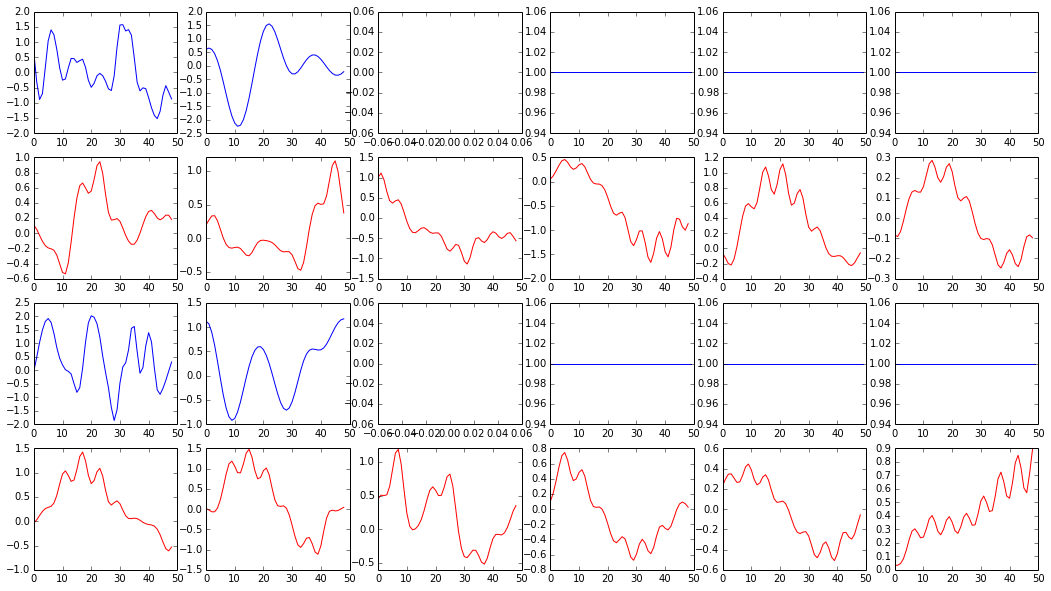

In [63]:
fig,axes = plt.subplots(nrows=S*2,ncols=P,figsize=(18,10))
for s in range(S):
    for p in range(P):
        if p <= uBar.shape[1]/N:
            axes[2*s+0,p].plot(uBar[s,p*N:p*N+N-1].T)
        else:
            axes[2*s+0,p].plot(np.ones(N).T)
        axes[2*s+1,p].plot(uExpBar[s,p*N:p*N+N-1].T,c='r')

In [260]:
A = YBar[0].T * YBar[0] +  YBar[1].T * YBar[1]
B = YBar.T * YBar


<matplotlib.colorbar.Colorbar instance at 0x7f2c045b4368>

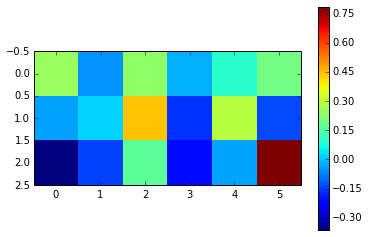

In [64]:
plt.imshow(phiHatExp,interpolation='none')
plt.colorbar()

In [53]:
Ynew = uExpBar*phiHatExpBar.T

0
1
2
3
4
5


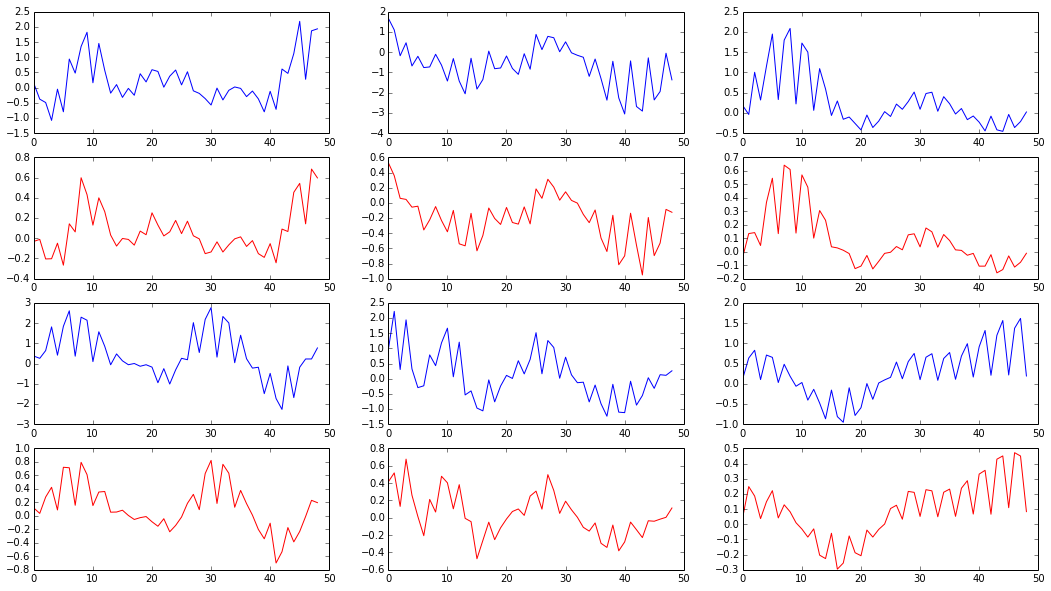

In [57]:
fig,axes = plt.subplots(nrows=S*2,ncols=C,figsize=(18,10))
for s in range(S):
    for p in range(C):
        print s*C+p
        if p <= YBar.shape[1]/N:
            axes[2*s+0,p].plot(YBar[s,p*N:p*N+N-1].T)
        else:
            axes[2*s+0,p].plot(np.ones(N).T)
        axes[2*s+1,p].plot(Ynew[s,p*N:p*N+N-1].T,c='r')

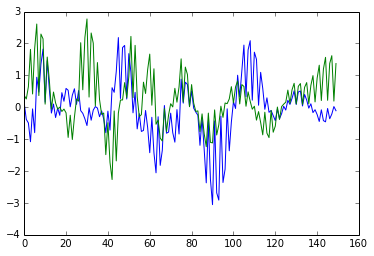

In [55]:
a=plt.plot(YBar.T)

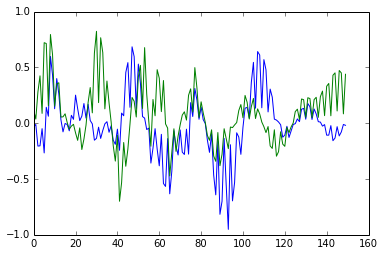

In [56]:
a=plt.plot(Ynew.T)